In [1]:
import sys
sys.path.append('/home/fdfuller/work/dgp_iwvi_gpflow2/')
import gpflow
import numpy as np
import tensorflow as tf
from typing import Tuple, Optional, List, Union, Callable
import dgp_iwvi_gpflow2.layers as layers
from dgp_iwvi_gpflow2.reference_spectra import *
from dgp_iwvi_gpflow2.exact_models import GPMM1D_Exact, GPMM2D_Exact, cartesian_prod
import attr
import tensorflow_probability as tfp
from matplotlib.pyplot import *
from gpflow.utilities import print_summary
import h5py
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
import dask
import dask.array as da
import scipy.stats as stats
import itertools
import math
from matplotlib import colors
from scipy.ndimage import uniform_filter1d
%matplotlib inline

In [2]:
def first_moment(axis, specs):
    return (axis[None,:]*specs/(specs.sum(-1)[:,None])).sum(-1)

def thresh_clean(X, thresh=0.01):
    Xm = X/X.max()
    mask = Xm<thresh
    X[mask] *= 0
    return X

def blank_shot_mask(X, thresh=0.01):
    Xm = X/X.max()
    return np.any(X>thresh, axis=-1)

In [3]:
file_tag = 'old_unthreshed_no_adj'
extra_tag = ''
pre_tag = 'trimmed_'
post_tag = '_data_run1'

In [4]:
    
with h5py.File('/home/fdfuller/work/data/sacla2017/clean_sorted_200mM_ferrocyanide_pink_all.h5','r') as fid:
    inp_axis = np.array(fid['inp_axis'])
    out_axis = np.array(fid['out_axis_binned'])

with h5py.File(f'/home/fdfuller/work/dgp_iwvi_gpflow2/notebooks/data_analysis/fake_data/{pre_tag}{file_tag}{extra_tag}{post_tag}.h5','r') as fid:
    Xpink_s = np.array(fid['X'])
    Ypink_s = np.array(fid['Y'])
    Xpink = np.array(fid['Xreal'])
    Ypink = np.array(fid['Yreal'])
    gt = np.array(fid['gt'])
    si = np.argsort(first_moment(inp_axis, Xpink_s))
    Xpink_s = Xpink_s[si,:]
    Ypink_s = Ypink_s[si,:]

    


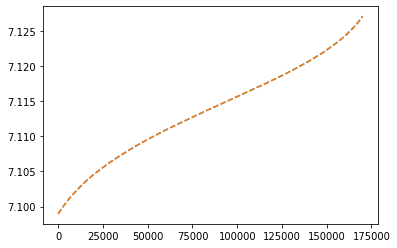

In [5]:
figure()
plot(first_moment(inp_axis, Xpink_s),'--')
plot(first_moment(inp_axis, Xpink),'--')

In [6]:
def G(x, alpha):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha\
                             * np.exp(-(x / alpha)**2 * np.log(2))

def unG(x, alpha):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.exp(-(x / alpha)**2 * np.log(2))

def L(x, gamma):
    """ Return Lorentzian line shape at x with HWHM gamma """
    l = 1 / ((np.pi*gamma)*(1 + x**2/gamma**2))
    return l/l.max()

def static_profile_correction(X, inp_axis, center, width):
    return X*L(inp_axis - center, width/2)[None,:]

def reverse_static_profile_correction(X, inp_axis, center, width):
    return X/L(inp_axis - center, width/2)[None,:]

def dynamic_profile_correction(X, inp_axis, center, width, n_modes=7, mode_width=0.01, blur_factor = 10):
    Nshots = X.shape[0]
    static_profile = np.exp(-(inp_axis - center)**2/(2*(width/2.355)**2))[None,:]
    mode_centers = np.random.normal(loc=center, scale=width/2.355, size=(Nshots, int(n_modes)))
    mode_amps = np.exp(-(mode_centers - center)**2/(2*(width/2.355)**2))[None,:]
    profiles = L(inp_axis[None,:,None] - mode_centers[:,None,:], mode_width/2).sum(-1)
    blurred_profile = uniform_filter1d(profiles,blur_factor,-1)
    blurred_profile /= blurred_profile.mean()
    return blurred_profile*X

def moment_dependent_profile_correction(X, inp_axis, center, slope, width, offset=7.113,
                                       profile_only=False):
    """
    Here we try the idea that the profile effect depends on the SASE first moment. We 
    define a profile with a center, similar to the static profile, then allow center to vary
    linearly as: slope*first_moment(X[j,:]) + center, keeping the width constant
    """
    μs = first_moment(inp_axis, X)
    if not profile_only:
        return X*L(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)
    else:
        return L(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)

def moment_dependent_dynamic_profile_correction(X, inp_axis, center, slope, width,
                                                amp_scale=0.1, noise_len_scale=0.1, offset=7.113,
                                                profile_only=False):
    """
    Here we try the idea that the profile effect depends on the SASE first moment. We 
    define a profile with a center, similar to the static profile, then allow center to vary
    linearly as: slope*first_moment(X[j,:]) + center, keeping the width constant
    """
    μs = first_moment(inp_axis, X)
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=noise_len_scale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    R = np.linalg.cholesky(K)
    R *= np.sqrt(amp_scale)
    corruption = (R @ np.random.normal(size=logX.shape).T).T
    warpedX = np.exp(logX + corruption)
    if not profile_only:
        return warpedX*L(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)
    else:
        return L(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)

def moment_dependent_profile_correction2(X, inp_axis, center, slope, width, offset=7.113,
                                        profile_only=False):
    """
    this version uses a gaussian intensity profile instead of a lorentzian
    
    Here we try the idea that the profile effect depends on the SASE first moment. We 
    define a profile with a center, similar to the static profile, then allow center to vary
    linearly as: slope*first_moment(X[j,:]) + center, keeping the width constant
    """
    μs = first_moment(inp_axis, X)
    if not profile_only:
        return X*(0.4+0.6*unG(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2))
    else:
        return (0.4+0.6*unG(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2))

def moment_dependent_dynamic_profile_correction2(X, inp_axis, center, slope, width,
                                                amp_scale=0.1, noise_len_scale=0.1, offset=7.113,
                                                profile_only=False):
    """
    This version uses a gaussian intensity profile instead of a lorentzian
    
    Here we try the idea that the profile effect depends on the SASE first moment. We 
    define a profile with a center, similar to the static profile, then allow center to vary
    linearly as: slope*first_moment(X[j,:]) + center, keeping the width constant
    """
    μs = first_moment(inp_axis, X)
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=noise_len_scale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    R = np.linalg.cholesky(K)
    R *= np.sqrt(amp_scale)
    corruption = (R @ np.random.normal(size=logX.shape).T).T
    warpedX = np.exp(logX + corruption)
    if not profile_only:
        return warpedX*G(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)
    else:
        return G(inp_axis[None,:] - (center + slope*(μs[:,None]-offset)), width/2)

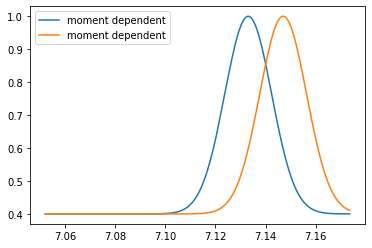

In [7]:
figure()
k = 500
# plot(inp_axis, static_profile_correction(Xpink_s, inp_axis, 7.130, 0.100)[k], label='static')
plot(inp_axis, moment_dependent_profile_correction2(Xpink_s, inp_axis, 7.140, 0.5, 0.022, profile_only=True)[k], label='moment dependent')
plot(inp_axis, moment_dependent_profile_correction2(Xpink_s, inp_axis, 7.140, 0.5, 0.022, profile_only=True)[-k], label='moment dependent')
legend()

In [8]:
def loggp_corrupt_sase(X, lenscale=0.1, amp_scale=0.1):
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    return np.exp(logX + corruption)

In [9]:
def loggp_corrupt_sase2(X, lenscale=0.1, amp_scale=0.1, elastic_scatter=0.0001, photon_scale=0.01):
    """This version simulates multiplicative noise + elastic scatter background due to a secondary 
        source that sprays light evenly over the whole frame. That light source is poisson sampled
    """
    e = (X.sum(-1)*elastic_scatter)[:,None]*np.ones_like(X)
    pe = np.random.poisson(e/photon_scale)*photon_scale
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    return np.exp(logX + corruption)+pe

In [10]:
def loggp_corrupt_sase3(X, lenscale=0.1, amp_scale=0.1, elastic_scatter=0.0001, photon_scale=0.01, blur_radius=10):
    """This version simulates multiplicative noise + elastic scatter background due to a secondary source
        very close to the sensor plane. So the light that is sprayed out depends on a blurred version
        of the spectrum itself (after multiplicative warping if any)
    """
    
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    warpedX = np.exp(logX + corruption)
    e = uniform_filter1d(warpedX,blur_radius,axis=-1)*elastic_scatter
    pe = np.random.poisson(e/photon_scale)*photon_scale
    return warpedX + pe

In [11]:
def loggp_poisson_corrupt_sase(X, lenscale=0.1, amp_scale=0.1, max_rate = 1000, trim=None):
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    if trim is not None:
        corruption[:,trim] *= 0.
    F = np.exp(logX + corruption)
    return np.random.poisson(F*max_rate).astype('float64')

In [12]:
def loggp_poisson_corrupt_sase2(X, lenscale=0.1, amp_scale=0.1, 
                               max_rate = 1000, blur_radius=15,
                               elastic_fraction=1E-3):
    logX = np.log(np.clip(X, a_min = 1e-6, a_max = None))
    kern = gpflow.kernels.RBF(lengthscales=lenscale, variance=1.0)
    K = kern(np.linspace(-1,1,X.shape[-1])[:,None], full_cov=True) + 1e-6*np.eye(X.shape[-1])
    L = np.linalg.cholesky(K)
    L *= np.sqrt(amp_scale)
    corruption = (L @ np.random.normal(size=logX.shape).T).T
    F = np.exp(logX + corruption)
    e = uniform_filter1d(F,blur_radius,axis=-1)*elastic_fraction
    return np.random.poisson((F+e)*max_rate).astype('float64')/max_rate

In [13]:
def poisson_corrupt_sase(X, alpha=500/3, maxnorm=True):
    Z = np.random.poisson(np.clip(X*alpha, a_min=1e-6, a_max=None)).astype('float64')
    if maxnorm:
        return Z/Z.max()
    else:
        return Z

In [14]:
def poisson_corrupt_sase2(X, alpha=500/3, maxnorm=True):
    """
    Like the loggp_corrupt_sase3: just elastic scatter contribution
    """
    e = uniform_filter1d(X,blur_radius,axis=-1)*elastic_scatter
    pe = np.random.poisson(e/photon_scale)*photon_scale
    return x + pe

In [34]:
sim_conditions = [
    {
        'noise_type': 'experimental',
        'controls': [None]
        
    },
    {
        'noise_type': 'no_noise',
        'controls': [None]
    },
    {
        'noise_type': 'poisson',
        'controls': [float(50)]
    },
    {
        'noise_type': 'multiplicative',
        'controls': [(0.1, 0.1)]
    },
    {
        'noise_type': 'moving_profile2',
        'controls': [(7.135, 0.5, 0.027)]
    }
]

In [35]:
pred_axis = np.linspace(inp_axis.max(),inp_axis.min(),1000)[:,None] #upsample by factor of 5
normalized_axis = np.linspace(-1,1,1000)[:,None]
sample_sizes = [10000]
for n,sim_condition in enumerate(sim_conditions):
    noise_type = sim_condition['noise_type']
    controls = sim_condition['controls']
    print(f'noise type is: {noise_type}')
    for control in controls:
        print(f'(condition {n}) control is: {control}')
        Ms_s = []
        Vs_s = []
        reports = []
        chunk_Ms_s = []
        for sample_size in sample_sizes:
            vs = []
            ms = []
            chunk_m1s = []
            slices = [slice(k,(k+1)*sample_size) for k in range(Xpink_s.shape[0]//sample_size)]
            k = 0
            for sel in slices:
                chunk_m1s.append(first_moment(inp_axis, Xpink_s[sel,:]).mean())
                if noise_type == 'poisson':
                    X = poisson_corrupt_sase(Xpink_s[sel,:], alpha=control, maxnorm=False)
                    print(f'mean photons in X: {X.sum(-1).mean()}')
                    X /= control
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'no_noise':
                    X = Xpink_s[sel,:]
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'experimental':
                    X = Xpink[sel,:]
                    Y = Ypink[sel,13][:,None]
                elif noise_type == 'multiplicative':
                    X = loggp_corrupt_sase(Xpink_s[sel,:], amp_scale=control[0], lenscale=control[1])
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'multiplicative_hf':
                    X = loggp_corrupt_sase3(Xpink_s[sel,:], amp_scale=control, lenscale=noise_lenscale, elastic_scatter=0.0005)
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'poisson_multiplicative':
                    X = loggp_poisson_corrupt_sase2(Xpink_s[sel,:], 
                                                   amp_scale=control, 
                                                   lenscale=noise_lenscale, max_rate=1000)
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'static_profile':
                    #width in units of keV; 0.05=50eV
                    X = static_profile_correction(Xpink_s[sel,:], inp_axis, center=control, width=0.10)
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'dynamic_profile':
                    X = dynamic_profile_correction(Xpink_s[sel,:], inp_axis, control, 0.120, n_modes=14)
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'moving_profile':
                    X = moment_dependent_profile_correction(Xpink_s[sel,:], inp_axis, control[0], control[1], width=control[2])
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'moving_dynamic_profile':
                    X = moment_dependent_dynamic_profile_correction(Xpink_s[sel,:], inp_axis, control[0], control[1], width=control[2])
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'moving_profile2':
                    X = moment_dependent_profile_correction2(Xpink_s[sel,:], inp_axis, control[0], control[1], width=control[2])
                    Y = Ypink_s[sel,13][:,None]
                elif noise_type == 'moving_dynamic_profile2':
                    X = moment_dependent_dynamic_profile_correction2(Xpink_s[sel,:], inp_axis, control[0], control[1], width=control[2])
                    Y = Ypink_s[sel,13][:,None]
                else:
                    raise ValueError('unexpected noise type')
                print(f'prepared data for fit {k}')
                data = (X, Y)
#                 model = GPMM1D_Exact(data, gpflow.kernels.Matern52(lengthscales=0.1, variance=0.01),
#                    noise_variance=data[1].var(), mean_function=gpflow.mean_functions.Zero(), jitter=1e-8)
                model = GPMM1D_Exact(data, gpflow.kernels.Matern52(lengthscales=0.1, variance=10E-3),
                   noise_variance=data[1].var(), mean_function=None, jitter=1e-7)
                #trigger compilation of loss
                loss_fn = model.training_loss
                loss_fn()
                opt = gpflow.optimizers.Scipy()
                reports.append(opt.minimize(loss_fn, model.trainable_variables, options=dict(maxiter=5000)))
                if not reports[-1]['success']:
                    print('optimization problem encountered')
                else:
                    print(f'finished fit {k}')
                m, v = model.predict_f(normalized_axis)
                ms.append(m)
                vs.append(v[:,None])
                k += 1
            Ms_s.append(np.concatenate(ms,-1))
            Vs_s.append(np.concatenate(vs,-1))
            chunk_Ms_s.append(np.array(chunk_m1s))

        for k, cm in enumerate(chunk_Ms_s):
            si = np.argsort(cm)
            chunk_Ms_s[k] = cm[si]
            Ms_s[k] = Ms_s[k][:,si]
            Vs_s[k] = Vs_s[k][:,si]

        np.save(f'./noise_sims/{file_tag}/{noise_type}_mus_final_sims_control_is_{control}.npy', chunk_Ms_s)
        np.save(f'./noise_sims/{file_tag}/{noise_type}_means_final_sims_control_is_{control}.npy', Ms_s)
        np.save(f'./noise_sims/{file_tag}/{noise_type}_vars_final_sims_control_is_{control}.npy', Vs_s)

noise type is: experimental
(condition 0) control is: None
prepared data for fit 0
finished fit 0
prepared data for fit 1
finished fit 1
prepared data for fit 2
finished fit 2
prepared data for fit 3
finished fit 3
prepared data for fit 4
finished fit 4
prepared data for fit 5
finished fit 5
prepared data for fit 6
finished fit 6
prepared data for fit 7
finished fit 7
prepared data for fit 8
finished fit 8
prepared data for fit 9
finished fit 9
prepared data for fit 10
finished fit 10
prepared data for fit 11
finished fit 11
prepared data for fit 12
finished fit 12
prepared data for fit 13
finished fit 13
prepared data for fit 14
finished fit 14
prepared data for fit 15
finished fit 15
prepared data for fit 16
finished fit 16
noise type is: no_noise
(condition 1) control is: None
prepared data for fit 0
finished fit 0
prepared data for fit 1
finished fit 1
prepared data for fit 2
finished fit 2
prepared data for fit 3
finished fit 3
prepared data for fit 4
finished fit 4
prepared data 

In [18]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

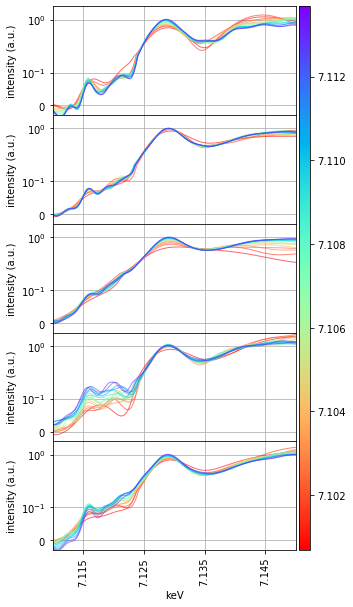

In [41]:
fig = figure(figsize=(5,10))
spec = gridspec.GridSpec(ncols=1, nrows=5, figure=fig)
fig.subplots_adjust(hspace=0, right=0.8)
axes = []
for k, sim_condition in enumerate(sim_conditions):
    noise_type = sim_condition['noise_type']
    control = sim_condition['controls'][0]
    Ms = np.load(f'./noise_sims/{file_tag}/{noise_type}_means_final_sims_control_is_{control}.npy')
    μs = np.load(f'./noise_sims/{file_tag}/{noise_type}_mus_final_sims_control_is_{control}.npy')
    if k > 0:
        axes.append(fig.add_subplot(spec[k,0], sharex=axes[-1]))
    else:
        axes.append(fig.add_subplot(spec[k,0]))
    
#     axes[-1].set_aspect(0.02)
    
    for M, μ, in zip(Ms, μs):
        cm = get_cmap('rainbow_r')
        axes[-1].set_prop_cycle(color=[cm(1.*i/M.shape[1]) for i in range(M.shape[1])])
        if not noise_type == 'experimental':
            axes[-1].plot(pred_axis-1e-3, M[:,:]/M[355,-1], alpha=min(1,10/M.shape[1]),linewidth=1.0)
#             axes[-1].plot(inp_axis-1e-3, gt[:,13], 'k--')
        else:
            axes[-1].plot(pred_axis, M[:,:]/M[365,-1], alpha=min(1,10/M.shape[1]),linewidth=1.0)
#             axes[-1].plot(inp_axis-1e-3, gt[:,13], 'k--')
        axes[-1].set_yscale('symlog', linthreshy=0.15)
        axes[-1].set_xlim([7.110,7.150])
        axes[-1].set_ylim([-0.03,2.0])
        axes[-1].set_yticks([0., 0.1, 1.0])
        axes[-1].set_xticks([])
        axes[-1].set_ylabel('intensity (a.u.)')
        grid()
        
axes[-1].set_xticks([7.115,7.125,7.135,7.145])
axes[-1].set_xticklabels([7.115,7.125,7.135,7.145], rotation=90)
axes[-1].set_xlabel('keV')
cb_ax = fig.add_axes([0.81, 0.125, 0.03, 0.755])
# cb_ax.axis('off')
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=μ.min(), vmax=μ.max(), clip=False),
                    cmap=get_cmap('rainbow_r')), cax=cb_ax)
savefig(f'./noise_sims/{file_tag}/figures/final_composite.pdf')
savefig(f'./noise_sims/{file_tag}/figures/final_composite.png')

In [220]:
Xms.shape

(3400,)

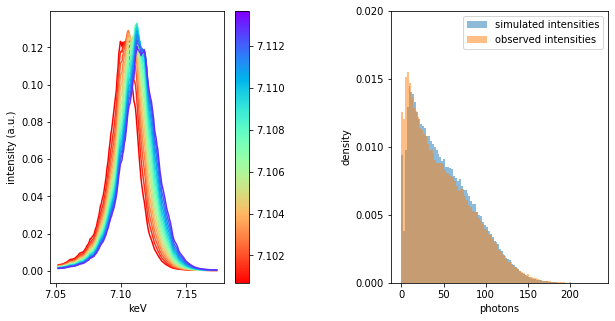

In [43]:
fig = figure(figsize=(10,5))
spec2 = gridspec.GridSpec(ncols=10, nrows=1, figure=fig)
p = 13
ax2 = fig.add_subplot(spec2[0,-4:])
ax2.hist(250*Ypink_s[:,p],100,density=True,alpha=0.5,label='simulated intensities');
ax2.hist(250*Ypink[:,p],100,density=True,alpha=0.5,label='observed intensities');
ax2.set_yticks([0.0, 5E-3, 1E-2, 1.5E-2, 2E-2])
ax2.set_xlabel('photons')
ax2.set_ylabel('density')
ax2.legend(loc=1)

cm = get_cmap('rainbow_r')
sim_condition = sim_conditions[0]
noise_type = sim_condition['noise_type']
control = sim_condition['controls'][0]
Ms = np.load(f'./noise_sims/{file_tag}/{noise_type}_means_final_sims_control_is_{control}.npy')
μs = np.load(f'./noise_sims/{file_tag}/{noise_type}_mus_final_sims_control_is_{control}.npy')
slices = [slice(k,(k+1)*sample_sizes[0]) for k in range(Xpink.shape[0]//sample_sizes[0])]
Xms = []
for sel in slices:
    Xms.append(Xpink[sel,:].mean(0))
Xms = np.stack(Xms,-1)

ax = fig.add_subplot(spec2[0,:4])
ax.set_prop_cycle(color=[cm(1.*i/M.shape[1]) for i in range(M.shape[1])])
ax.plot(inp_axis, Xms)
ax.set_xlabel('keV')
ax.set_ylabel('intensity (a.u.)')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=μs.min(), vmax=μs.max(), clip=False),
                            cmap=get_cmap('rainbow_r')), ax=ax)
savefig(f'./noise_sims/{file_tag}/figures/final_supplement.pdf')
savefig(f'./noise_sims/{file_tag}/figures/final_supplement.png')